In [329]:
# import
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [330]:
# constants
c = 3 * 10 **8
e = 1.6 * 10 **-19
ϵ0 = 8.854 * 10 **-12
me = 0.511 / c**2
mp = 938 / c**2
N_A = 6.022 * 10 **23
m_α = 3727.379 / c**2
W_air = 85.7 * 10 **-6
W_He = 41.8 * 10 **-6
W_Ar = 187 * 10 **-6
Z_α = 2
Ekin_α = 5.486
k_b = 1.38 * 10 **-23
k_air = 14.4
k_He = 2
k_Ar = 18
# MeV/J
MeV_J = 1/e * 10**-6

In [357]:
#measured data
ρ = 0.053
ρ_err = 0.001

background_n = 854
background_n_err = np.sqrt(background_n )
background_t = 3323
background_t_err = 1
background = background_n/background_t
background_err = np.sqrt((background_n_err/background_t)**2+(background_t_err*background_n/background_t**2)**2)

data_n = [434,612,1069,1104,1176,1298,1561,1672,1678,1716,1801,1656,1950,1661,1698,1772,1620,1415,1220,1156,1105,1052,1032,981,910,919,881,852,910,905,904,877,846,809,728,528,402,101,104]
data_n_err = [np.sqrt(n)for n in data_n]
data_t = [992.4,613.4,654.3,520.0,466.8,459.2,488.1,495.6,490.1,461.5,479.9,437.1,493.9,452.9,460.8,488.6,477.8,444.1,411.2,408.8,446.9,469.8,512.0,519.1,498.0,503.8,507.8,495.9,504.0,495.6,498.8,503.6,492.9,502.9,511.5,528.11,713.5,370.5,406]
data_t_err = 0.1
data_I = [1407,1307,1237,1189,1138,1088,1038,998,969,939,909,878,848,818,788,748,709,669,629,589,549,509,478,459,439,418,398,378,358,338,318,298,278,258,238,208,158,108,58]
data_I_err = [I*0.01+1 for I in data_I ]


countrate = []
countrate_err = []
for i in range(len(data_n)):
    countrate.append(data_n[i]/data_t[i]-background)
    countrate_err.append(np.sqrt((data_n_err[i]/data_t[i])**2+(data_t_err*data_n[i]/data_t[i]**2)**2+(background_err)**2))
    

#calibration data
input = 'Data/magnetic_calibration.txt'
i = 0
cal_I = []
cal_B = []
for line in open(input):
    
    if(i > 1):
        d = line.split("\t")
        cal_I.append(float(d[0]))
        cal_B.append(float(d[1]))
    i = i + 1
    
#coulomb correction
G_p = []
G_E = []
G_38 = []
G_39 = []
G_40 = []
i=0
input = 'Data/correction.txt'
for line in open(input):
    
    if(i > 1):
        line = line.replace(",",".")
        d = line.split("\t")
        G_p.append(float(d[0]))
        G_E.append(float(d[1]))
        G_38.append(float(d[2]))
        G_39.append(float(d[3]))
        G_40.append(float(d[4]))
    i = i + 1

    
#countrate
#countrate_err

In [358]:
#theoretical functions
def g(x,m,b):
    return m*x+b

def E_kin(p):
    return np.sqrt(p**2+me**2)-me


def G(E,E_array,G_array):
    i=0
    
    for x in E_array:
        if E<x:
            break
        i+=1 
        if(i>len(G_array)-3):
            break
    result = G_array[i]+(G_array[i+1]-G_array[i])/(E_array[i+1]-E_array[i])*E
    return result 


def curie(N,p):
    En = E_kin(p)
    print(len(E))
    Cor = [G(pi,G_E,G_38) for pi in p]
    print(len(Cor))
    print(len(p))
    print(len(N))
    return abs(np.sqrt(N/(p**2*En*Cor)))

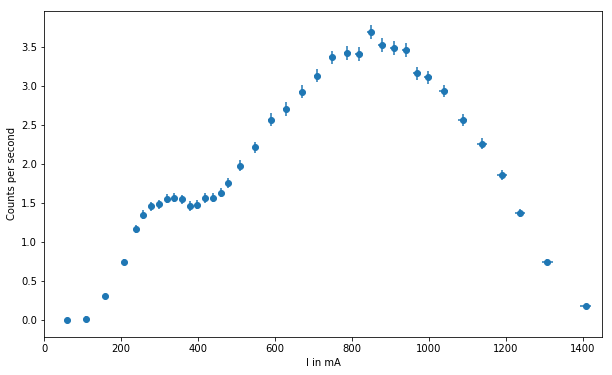

In [360]:
#plot of the counting rate
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(data_I,countrate)
ax.errorbar(data_I,countrate,yerr=countrate_err,xerr=data_I_err,ls="")
ax.set_xlim([0,1450])
ax.set_ylabel("Counts per second")
ax.set_xlabel("I in mA")

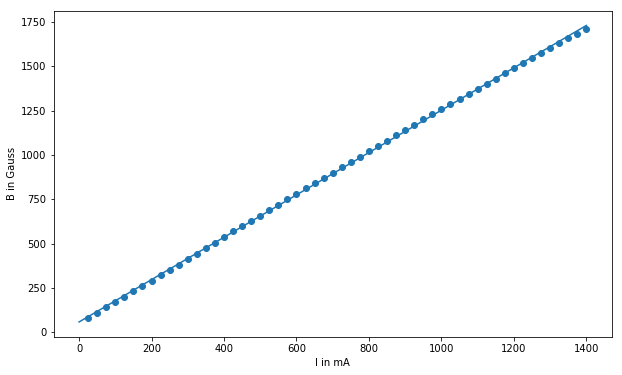

In [361]:
#calibration of the magnetic field
popt,pcov = curve_fit(g,cal_I,cal_B)

t=np.linspace(0,1400,100)
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(cal_I,cal_B)
ax.plot(t,g(t,*popt))
ax.set_xlabel("I in mA")
ax.set_ylabel("B in Gauss")

B = g(np.array(data_I),*popt)*10**-4
B_err = [0.003*b for b in B]

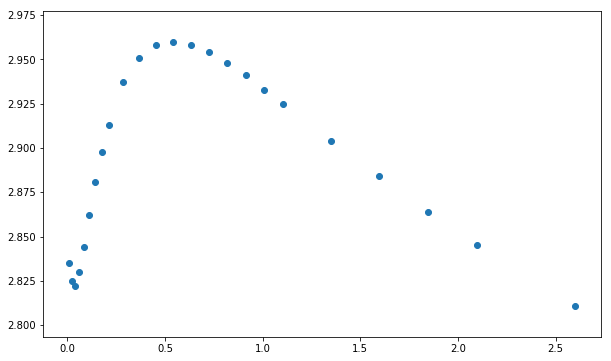

In [362]:
# G interpolation

t = np.linspace(0,2.5)
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(G_E,G_38)
#ax.plot(t,G(t,*popt))

In [363]:
p = B*ρ*e*(c/e*10**-6)
E = E_kin(p)


(0, 3)

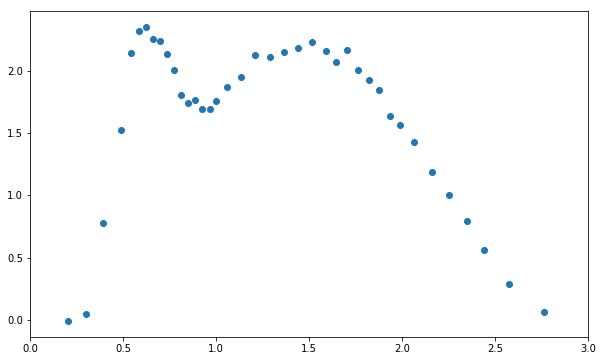

In [364]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(p,countrate/p)
ax.set_xlim(0,3)

39
39
39
39


/home/julian/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in sqrt


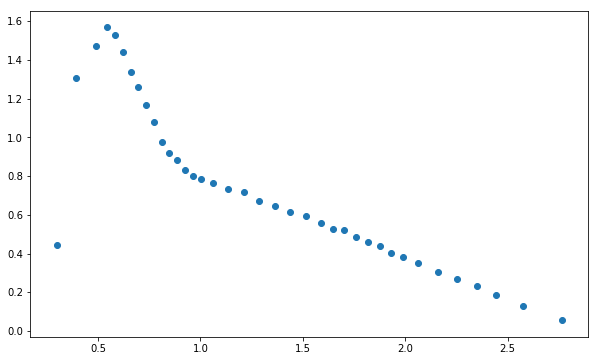

In [365]:
#Curie Plot
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(E,curie(countrate,p))
